In [1]:
from surface_metrics.lesion_wise_dist import LesionWiseDist
from surface_metrics.cluster_dist import ClusterDist
from surface_metrics.region_dist import RegionDist

from surface_metrics.legacy_dist import compute_surface_distances
from surface_metrics.legacy_dist import compute_robust_hausdorff

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import cc3d

import numpy as np

# Utils

In [3]:
def plot(pred, gt_display):
    pred = pred
    gt_display = gt_display
    gt_display = gt_display*2

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(pred[0, :, :], cmap='gray')
    ax[0].set_title('Prediction')

    ax[1].imshow(gt_display[0, :, :], cmap='gray')
    ax[1].set_title('Ground Truth')

    combined = pred + gt_display

    ax[2].imshow(combined[0, :, :], cmap='rainbow')
    ax[2].set_title('Overlay (Prediction + Ground Truth)')

    legend_elements = [Patch(facecolor='purple', edgecolor='black', label='TN'),
                    Patch(facecolor='turquoise', edgecolor='black', label='FP'),
                    Patch(facecolor='yellow', edgecolor='black', label='FN'),
                    Patch(facecolor='red', edgecolor='black', label='TP')]

    ax[2].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))

    plt.show()

def scores(pred, gt):
    # Compute normal surface distances
    surface_distances = compute_surface_distances(pred.astype(bool), gt.astype(bool), [1, 1, 1])
    hd95_score = compute_robust_hausdorff(surface_distances, 95)

    # compute connected components
    pred_label_cc = cc3d.connected_components(pred.astype(bool))
    gt_label_cc = cc3d.connected_components(gt.astype(bool))

    # Compute the metrics
    lesion_wise_dist_score = LesionWiseDist(pred_label_cc, gt_label_cc)
    cluster_dist_score = ClusterDist(pred_label_cc, gt_label_cc)
    region_dist_score = RegionDist(pred, gt)

    print(f'Lesion-wise distance: {lesion_wise_dist_score}')
    print(f'Cluster distance: {cluster_dist_score}')
    print(f'Region distance: {region_dist_score}')
    print(f'HD95: {hd95_score}')


# Where 'Dice' Fails -  *Unfair weighing of instances*

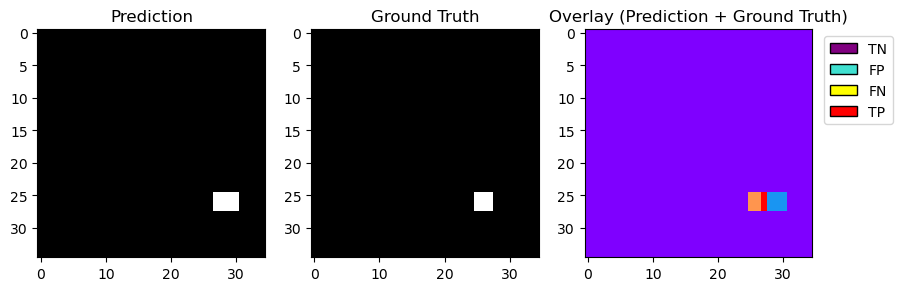

Lesion-wise distance: 3.0
Cluster distance: 3.0
Region distance: 3.0
HD95: 3.0


In [4]:
pred = np.zeros((10, 35, 35))
gt   = np.zeros((10, 35, 35))

# pred[0, 1:23, 1:23] = 1
# gt[0, 1:23, 1:23] = 1

pred[0, 25:28, 27:31] = 1
gt[0, 25:28, 25:28] = 1

plot(pred, gt*2)
scores(pred, gt)

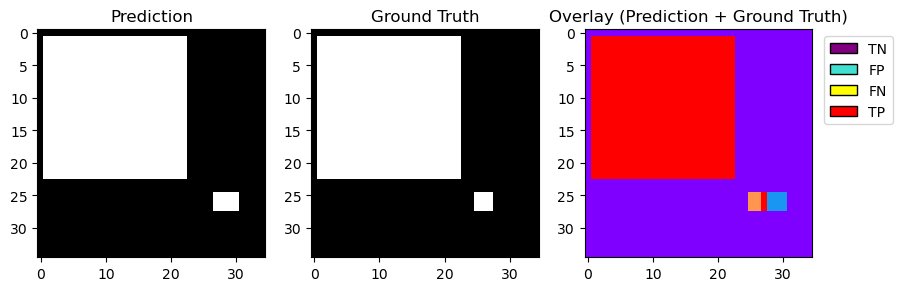

Lesion-wise distance: 1.5
Cluster distance: 1.5
Region distance: 1.5
HD95: 0.0


In [5]:
pred = np.zeros((35, 35))
gt   = np.zeros((35, 35))

pred[1:23, 1:23] = 1
gt[1:23, 1:23] = 1

pred[25:28, 27:31] = 1
gt[25:28, 25:28] = 1

plot(pred[np.newaxis, ...], gt[np.newaxis, ...]*2)
scores(pred[np.newaxis, ...], gt[np.newaxis, ...])

# Where Panoptic Quality & Lesion-wise Dice Fails - *2 Ground Truths and 1 Prediction*

<ins> Panoptic quality fails </ins> because they do not take into accoutn multiple ground truths: (below from the paper itself)

(1) during matching, group regions are not used, and 

(2) after matching, unmatched predicted segments that contain a fraction of pixels from a group of the same class over the matching threshold are removed and do not count as false positives.

<ins> Lesion-wise Dice fails </ins> because the ground prediction is matched to both, and hence the false positive is being penalised twice.

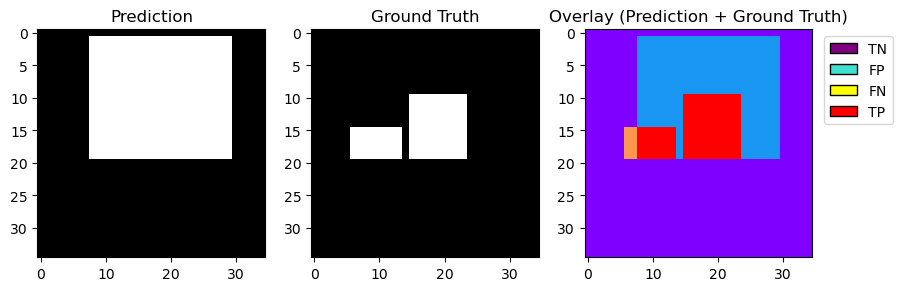

Lesion-wise distance: 13.04400374531753
Cluster distance: 9.0
Region distance: 9.0
HD95: 9.0


In [6]:
pred = np.zeros((10, 35, 35))
gt   = np.zeros((10, 35, 35))

gt[0, 15:20, 6:14] = 1
gt[0, 10:20, 15:24] = 1
pred[0, 1:20, 8:30] = 1

plot(pred, gt*2)
scores(pred, gt)

# Lesion-wise Dice and Panoptic Quality are assymmetrical; Cluster Dice is not

Also a representation of the combination of failure cases.

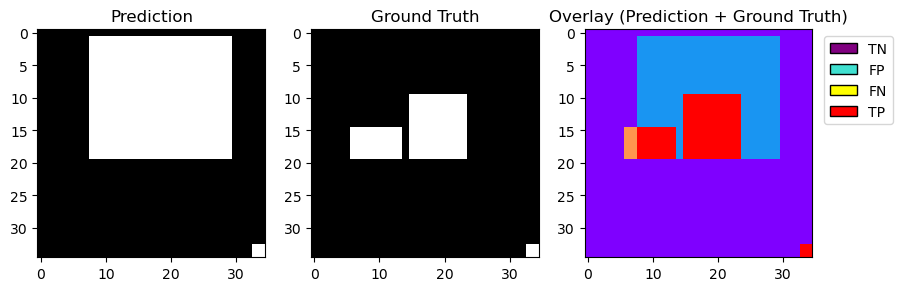

Lesion-wise distance: 8.696002496878354
Cluster distance: 4.5
Region distance: 4.5
HD95: 9.0


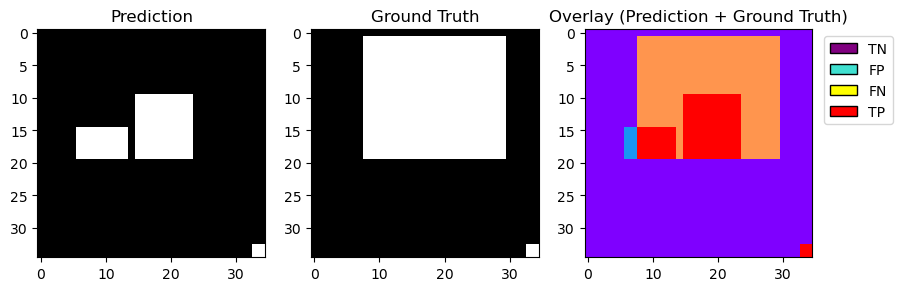

Lesion-wise distance: 4.5
Cluster distance: 4.5
Region distance: 4.5
HD95: 9.0


In [7]:
pred = np.zeros((10, 35, 35))
gt   = np.zeros((10, 35, 35))

gt[0, 15:20, 6:14] = 1
gt[0, 10:20, 15:24] = 1
pred[0, 1:20, 8:30] = 1

#standalone prediction
gt[0, 33:35, 33:35] = 1
pred[0, 33:35, 33:35] = 1

plot(pred, gt*2)
scores(pred, gt)

###################################

pred = np.zeros((10, 35, 35))
gt   = np.zeros((10, 35, 35))

pred[0, 15:20, 6:14] = 1
pred[0, 10:20, 15:24] = 1
gt[0, 1:20, 8:30] = 1

#standalone prediction
gt[0, 33:35, 33:35] = 1
pred[0, 33:35, 33:35] = 1

plot(pred, gt*2)
scores(pred, gt)

# Where All perform equally - 2 Predictions on 1 Ground Truth 

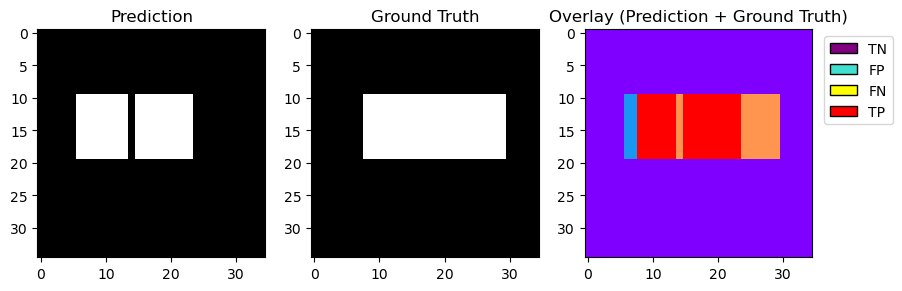

Lesion-wise distance: 5.0
Cluster distance: 5.0
Region distance: 5.0
HD95: 5.0


In [8]:
pred = np.zeros((10, 35, 35))
gt   = np.zeros((10, 35, 35))

#half of the prediction is correct
pred[0, 10:20, 6:14] = 1
pred[0, 10:20, 15:24] = 1
gt[0, 10:20, 8:30] = 1

plot(pred, gt*2)
scores(pred, gt)

# Cluster Dice ensures proper pixel-wsie assignment

In the below case: Representation of improper pixel-wise assignment. 

Taking the bottom GT lesion, it will be assigned the bottom two Pred lesions. However, that will cause the edge pixels, which are actually true positive to be calculated as false positives. This is not reflected in the "component" wise assignment but on a pixel level, they are treated seperately. This does occur in C-Dice as it is evaluated as a whole.

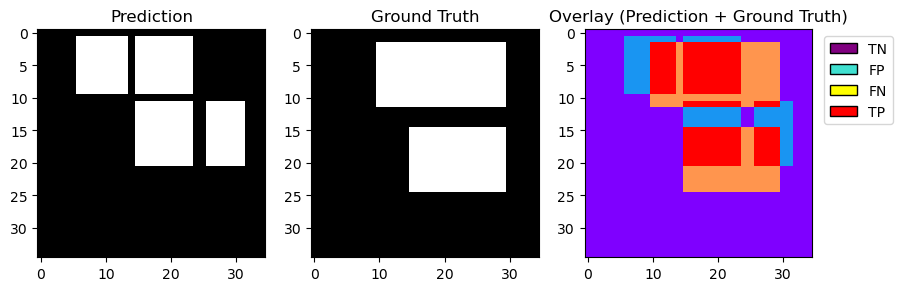

Lesion-wise distance: 6.0
Cluster distance: 4.0
Region distance: 4.0
HD95: 4.0


In [9]:
pred = np.zeros((10, 35, 35))
gt   = np.zeros((10, 35, 35))

pred[0, 1:10, 6:14] = 1
pred[0, 1:10, 15:24] = 1
pred[0, 11:21, 15:24] = 1
pred[0, 11:21, 26:32] = 1

gt[0, 2:12, 10:30] = 1
gt[0, 15:25, 15:30] = 1

plot(pred, gt*2)
scores(pred, gt)

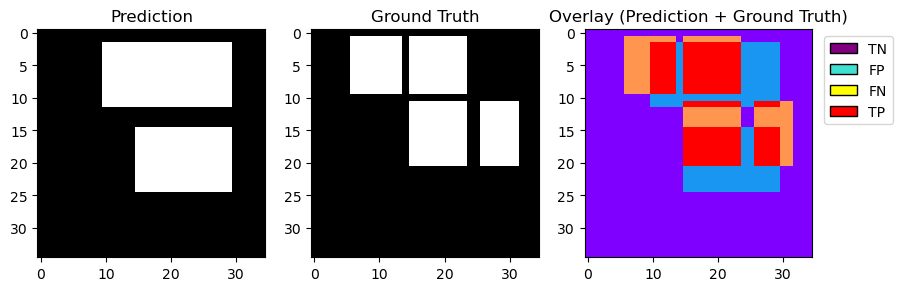

Lesion-wise distance: 11.043954530431744
Cluster distance: 4.0
Region distance: 4.0
HD95: 4.0


In [10]:
pred = np.zeros((10, 35, 35))
gt   = np.zeros((10, 35, 35))

gt[0, 1:10, 6:14] = 1
gt[0, 1:10, 15:24] = 1
gt[0, 11:21, 15:24] = 1
gt[0, 11:21, 26:32] = 1

pred[0, 2:12, 10:30] = 1
pred[0, 15:25, 15:30] = 1

plot(pred, gt*2)
scores(pred, gt)

# Cluster dice is more sensitive to false-positives

The reduction in panoptic quality and lesion dice is much less as opposed to instance dice.

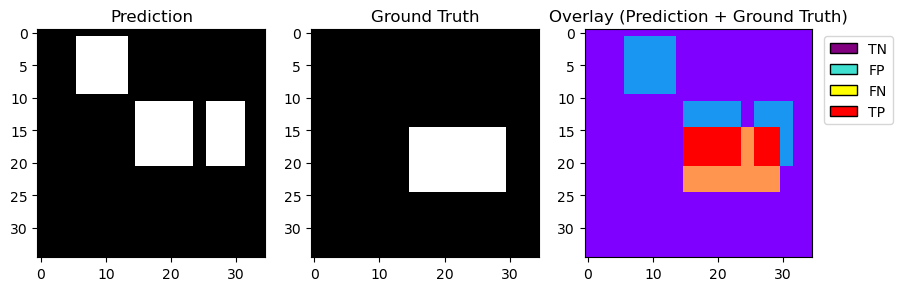

Lesion-wise distance: 189.0
Cluster distance: inf
Region distance: inf
HD95: 13.92838827718412


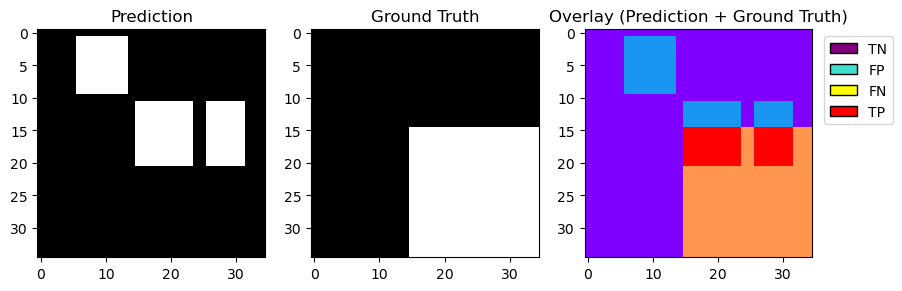

Lesion-wise distance: 193.5
Cluster distance: inf
Region distance: inf
HD95: 13.92838827718412


In [11]:
pred = np.zeros((10, 35, 35))
gt   = np.zeros((10, 35, 35))

pred[0, 1:10, 6:14] = 1

pred[0, 11:21, 15:24] = 1
pred[0, 11:21, 26:32] = 1

gt[0, 15:25, 15:30] = 1

plot(pred, gt*2)
scores(pred, gt)

##############################

pred = np.zeros((10, 35, 35))
gt   = np.zeros((10, 35, 35))

pred[0, 1:10, 6:14] = 1

pred[0, 11:21, 15:24] = 1
pred[0, 11:21, 26:32] = 1

gt[0, 15:35, 15:35] = 1

plot(pred, gt*2)
scores(pred, gt)

# Case where the choice of Matching Really Shines!!

Cluster: Overall High score

Panoptic: Only choose the best pred

Lesion-Wise: Penalise Heavily

Normal: Just normal!

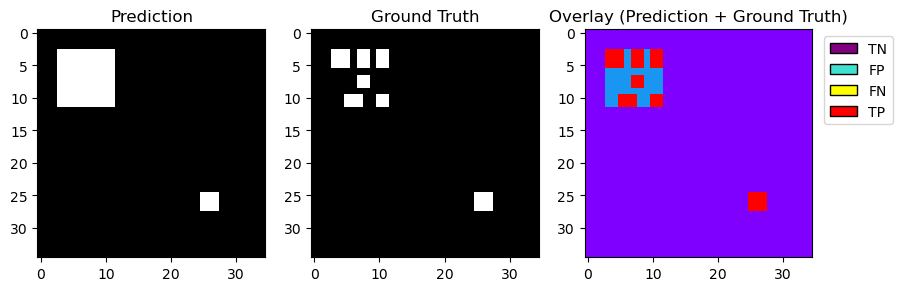

Lesion-wise distance: 5.705876181708518
Cluster distance: 1.0
Region distance: 1.0
HD95: 2.0


In [12]:
pred = np.zeros((10, 35, 35))
gt   = np.zeros((10, 35, 35))

gt[0, 3:6, 3:6] = 1
gt[0, 3:6, 7:9] = 1
gt[0, 3:6, 10:12] = 1
gt[0, 7:9, 7:9] = 1
gt[0, 10:12, 10:12] = 1
gt[0, 10:12, 5:8] = 1

pred[0, 3:12, 3:12] = 1

pred[0, 25:28, 25:28] = 1
gt[0, 25:28, 25:28] = 1

plot(pred, gt*2)
scores(pred, gt)

# Special Cases

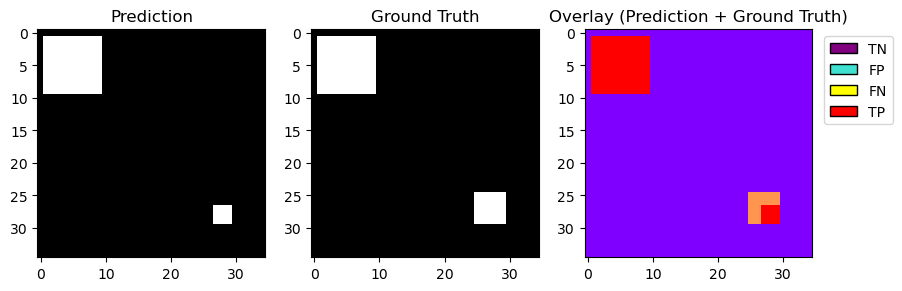

Lesion-wise distance: 1.118033988749895
Cluster distance: 1.118033988749895
Region distance: 1.118033988749895
HD95: 2.0


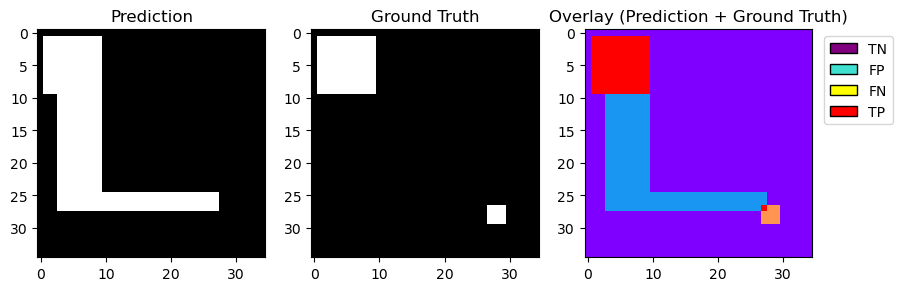

Lesion-wise distance: 27.467479631738684
Cluster distance: 16.0
Region distance: 16.0
HD95: 16.0


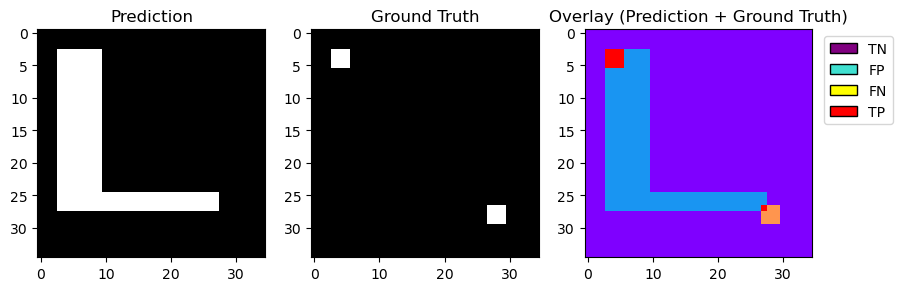

Lesion-wise distance: 29.09834208914769
Cluster distance: 20.0
Region distance: 20.0
HD95: 20.0


In [13]:
pred = np.zeros((10, 35, 35))
gt   = np.zeros((10, 35, 35))

pred[0, 1:10, 1:10] = 1
gt [0, 1:10, 1:10] = 1

pred[0, 27:30, 27:30] = 1
gt [0, 25:30, 25:30] = 1

plot(pred, gt*2)
scores(pred, gt)

##############################

pred = np.zeros((10, 35, 35))
gt   = np.zeros((10, 35, 35))

gt[0, 1:10, 1:10] = 1
pred [0, 1:10, 1:10] = 1

gt[0, 27:30, 27:30] = 1

pred [0, 25:28, 25:28] = 1
pred [0, 25:28, 3:28] = 1
pred [0, 3:28, 3:10] = 1

plot(pred, gt*2)
scores(pred, gt)

##############################

pred = np.zeros((10, 35, 35))
gt   = np.zeros((10, 35, 35))

gt[0, 3:6, 3:6] = 1
pred [0, 3:6, 3:6] = 1

gt[0, 27:30, 27:30] = 1

pred [0, 25:28, 25:28] = 1
pred [0, 25:28, 3:28] = 1
pred [0, 3:28, 3:10] = 1

plot(pred, gt*2)
scores(pred, gt)

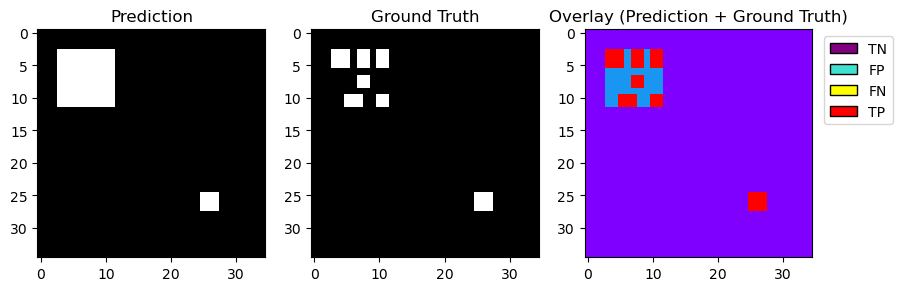

Lesion-wise distance: 5.705876181708518
Cluster distance: 1.0
Region distance: 1.0
HD95: 2.0


In [14]:
pred = np.zeros((10, 35, 35))
gt   = np.zeros((10, 35, 35))

gt[0, 3:6, 3:6] = 1
gt[0, 3:6, 7:9] = 1
gt[0, 3:6, 10:12] = 1
gt[0, 7:9, 7:9] = 1
gt[0, 10:12, 10:12] = 1
gt[0, 10:12, 5:8] = 1

pred[0, 3:12, 3:12] = 1

pred[0, 25:28, 25:28] = 1
gt[0, 25:28, 25:28] = 1

plot(pred, gt*2)
scores(pred, gt)